# Содержание

* [1 Подготовка окружения](#1-Подготовка-окружения)
* [2 Mona Liza reconstruction](#2-Mona-Liza-reconstruction)

# Лабораторная работа №3: Дифференциальный рендеринг

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tidalinn/mai_term03_artificial_intelligence_course/blob/main/03_laboratory_work.ipynb)

>GPU activation: Runtime → Change runtime type → T4 GPU

**Задачи:**

1. Воспроизвести эксперимент с Мона Лизой по статье [3D ML. Часть 4: дифференциальный рендеринг](https://habr.com/ru/companies/itmai/articles/520268/).
2. Произвести тот же эксперимент на своём лице (подогнать фото по размерам изображения с Мона Лизой и переложить на чёрный фон).

**Источники данных:** [Basel face model (2017 version)](https://faces.dmi.unibas.ch/bfm/bfm2017.html)

**Описание данных:** изображения.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1. Подготовка окружения

Для работы с примером вам потребуется датасет [Basel face model (2017 version)](http://gravis.dmi.unibas.ch/PMM/data/overview/). Файл model2017-1_bfm_nomouth.h5 необходимо будет разместить в рабочей директории вместе с кодом.

In [1]:
!python --version

Python 3.10.12


06/12/2020 - Python 3.8 support. [Installation](https://github.com/BachiLi/redner/wiki/Installation)

**Miniconda**

In [2]:
%%capture no-display
import sys

path_conda = !which conda

if len(path_conda) == 0:
    %env PYTHONPATH = # /env/python

    !wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
    !chmod +x Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
    !./Miniconda3-py38_23.11.0-2-Linux-x86_64.sh -b -f -p /usr/local Y
    !conda update conda

    sys.path.append('/usr/local/lib/python3.8/site-packages')

    !conda create -y -n myenv python=3.8

In [3]:
!which python

/usr/local/bin/python


In [22]:
%%bash
source activate myenv

python --version
conda --version

Python 3.8.18
conda 23.11.0


---

Импорт библиотек:

In [46]:
%%capture no-display
%%bash
source activate myenv

pip install torch torchvision numpy
pip install redner-gpu
pip install h5py matplotlib urllib3 ipython pillow

In [28]:
%%bash
source activate myenv
python

import pyredner

print('Current device:', pyredner.get_device())

Device: cuda


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Mona Liza reconstruction

In [58]:
import os

import matplotlib.pyplot as plt

In [66]:
join_path = lambda x: os.path.join('/content/', x)

In [94]:
%%bash
source activate myenv
python

import torch
import pyredner
import h5py
import urllib
import time
import os

from IPython.display import HTML, display, clear_output
from matplotlib import animation
from PIL import Image


join_path = lambda x: os.path.join('/content/', x)


'''
Загрузка датасета лиц
'''

print('1. Loading the Basel face model')

with h5py.File(r'/content/model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(
        hf['shape/model/mean'],
        device = pyredner.get_device()
    )

    shape_basis = torch.tensor(
        hf['shape/model/pcaBasis'], # базисный вектор формы
        device = pyredner.get_device()
    )

    triangle_list = torch.tensor(
        hf['shape/representer/cells'],
        device = pyredner.get_device()
    )

    color_mean = torch.tensor(
        hf['color/model/mean'],
        device = pyredner.get_device()
    )

    color_basis = torch.tensor(
        hf['color/model/pcaBasis'], # базисный вектор цвета
        device = pyredner.get_device()
    )


'''
Создание модели, которая на вход будет принимать векторы скрытого представления \
цвета и формы лица, параметры камеры и освещения в сцене, а на выходе будет \
генерировать отрендеренное изображение
'''

print('2. Getting average face geometry')

indices = triangle_list.permute(1, 0).contiguous() # хранит геометрию усредненного лица в форме полигональной модели


print('3. Creating the model')

def model(cam_pos,
          cam_look_at,
          shape_coeffs,
          color_coeffs,
          ambient_color,
          dir_light_intensity):

    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = pyredner.compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)

    m = pyredner.Material(use_vertex_color = True)

    obj = pyredner.Object(
        vertices=vertices,
        indices=indices,
        normals=normals,
        material=m,
        colors=colors
    )

    cam = pyredner.Camera(
        position=cam_pos,
        # Center of the vertices
        look_at=cam_look_at,
        up=torch.tensor([0.0, 1.0, 0.0]),
        fov=torch.tensor([45.0]),
        resolution=(256, 256)
    )

    scene = pyredner.Scene(camera=cam, objects=[obj])

    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0]), dir_light_intensity)

    img = pyredner.render_deferred(scene=scene, lights=[ambient_light, dir_light])

    return img


'''
Задание первоначальных параметров освещения и позиции камеры и применение модели
'''

print('4. Creating params')

cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277])
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918])

img = model(
    cam_pos,
    cam_look_at,
    torch.zeros(199, device=pyredner.get_device()),
    torch.zeros(199, device=pyredner.get_device()),
    torch.ones(3),
    torch.zeros(3)
)

torch.save(torch.pow(img, 1.0/2.2).cpu(), '/content/init.pt')


'''
Загрузка целевого изображения, параметры которого нужно восстановить
'''

face_url = 'https://raw.githubusercontent.com/BachiLi/redner/master/tutorials/mona-lisa-cropped-256.png'

urllib.request.urlretrieve(face_url, 'target.png')
target = pyredner.imread('target.png').to(pyredner.get_device())

torch.save(torch.pow(target, 1.0 / 2.2).cpu(), '/content/target.pt')


'''
Зададим начальные значения параметров, которые будем пытаться восстановить для целевой картины.
'''

# Set requires_grad=True since we want to optimize them later
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], requires_grad=True)
shape_coeffs = torch.zeros(199, device=pyredner.get_device(), requires_grad=True)
color_coeffs = torch.zeros(199, device=pyredner.get_device(), requires_grad=True)
ambient_color = torch.ones(3, device=pyredner.get_device(), requires_grad=True)
dir_light_intensity = torch.zeros(3, device=pyredner.get_device(), requires_grad=True)

# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam([
    shape_coeffs,
    color_coeffs,
    ambient_color,
    dir_light_intensity
], lr=0.1)

cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)




imgs, losses = [], []

# Run 500 Adam iterations
num_iters = 500

for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()

    img = model(cam_pos, cam_look_at, shape_coeffs, color_coeffs, ambient_color, dir_light_intensity)

    # Compute the loss function. Here it is L2 plus a regularization
    # term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space,
    # so no gamma correction is needed.

    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()

    optimizer.step()
    cam_optimizer.step()

    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)

    losses.append(loss.data.item())

    # Only store images every 10th iterations
    if t % 10 == 0:
        # Record the Gamma corrected image
        imgs.append(torch.pow(img.data, 1.0 / 2.2).cpu())


torch.save(imgs, 'imgs.pt')

with open('losses.txt', 'w+') as file:
    for loss in losses:
        file.write('%s\n' %loss)

1. Loading the Basel face model
2. Getting average face geometry
3. Creating the model
4. Creating params
Scene construction, time: 0.07745 s
Forward pass, time: 0.04501 s
Scene construction, time: 0.01575 s
Forward pass, time: 0.02707 s
Backward pass, time: 0.16366 s
Scene construction, time: 0.01528 s
Forward pass, time: 0.02668 s
Backward pass, time: 0.16086 s
Scene construction, time: 0.01335 s
Forward pass, time: 0.02569 s
Backward pass, time: 0.12984 s
Scene construction, time: 0.01146 s
Forward pass, time: 0.02274 s
Backward pass, time: 0.13142 s
Scene construction, time: 0.01053 s
Forward pass, time: 0.02388 s
Backward pass, time: 0.12664 s
Scene construction, time: 0.00979 s
Forward pass, time: 0.02178 s
Backward pass, time: 0.12220 s
Scene construction, time: 0.00982 s
Forward pass, time: 0.02126 s
Backward pass, time: 0.12551 s
Scene construction, time: 0.01020 s
Forward pass, time: 0.02177 s
Backward pass, time: 0.12385 s
Scene construction, time: 0.00963 s
Forward pass, ti

<stdin>:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
/usr/local/envs/myenv/lib/python3.8/site-packages/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))
/usr/local/envs/myenv/lib/python3.8/site-packages/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))


In [95]:
import matplotlib.pyplot as plt

import torch

import h5py
import urllib

In [96]:
init = torch.load('/content/init.pt')
target = torch.load('/content/target.pt')

In [97]:
imgs = torch.load('/content/imgs.pt')

In [98]:
with open('/content/losses.txt', 'rb') as file:
    losses = [float(line.strip()) for line in file]

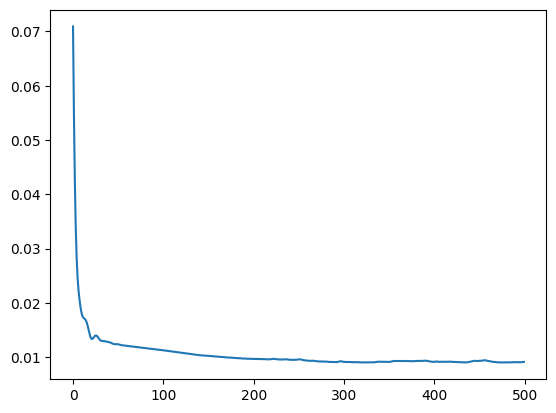

In [99]:
plt.plot(losses)

<ipython-input-100-a2586d3d5ab4>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6, 6))


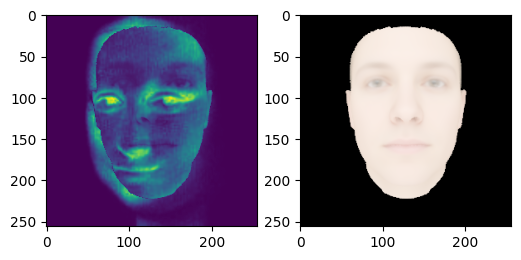

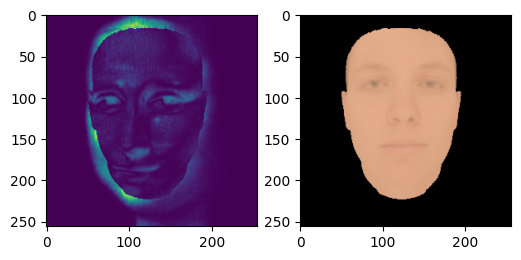

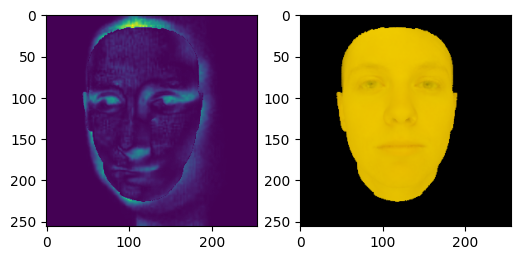

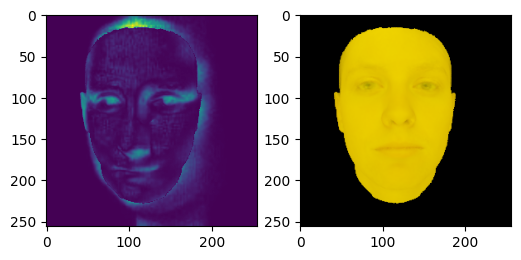

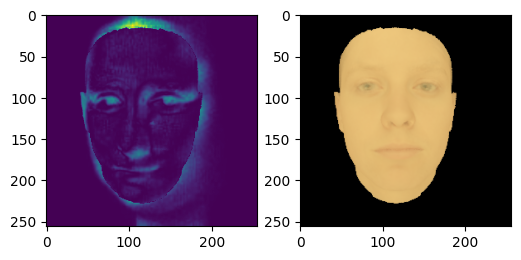

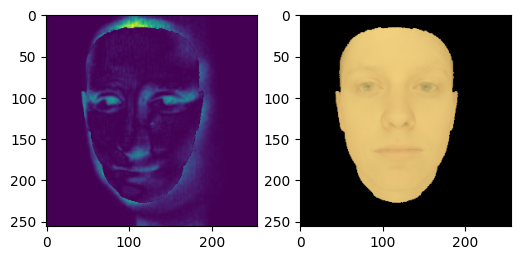

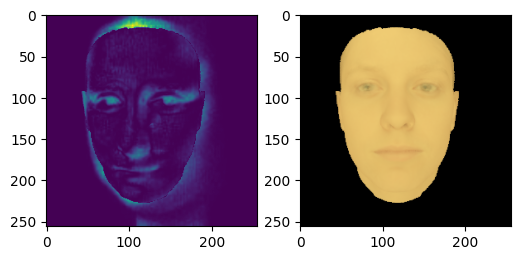

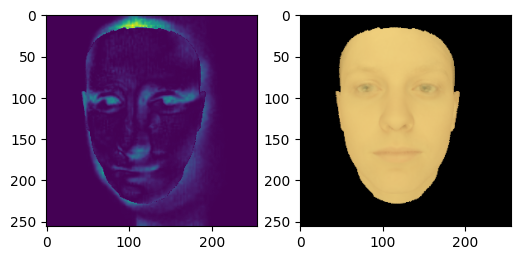

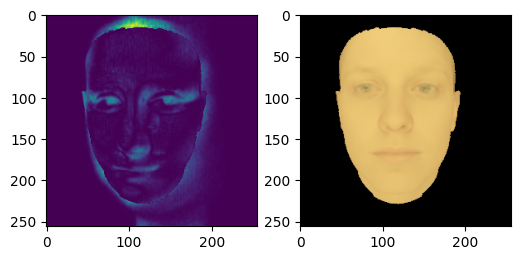

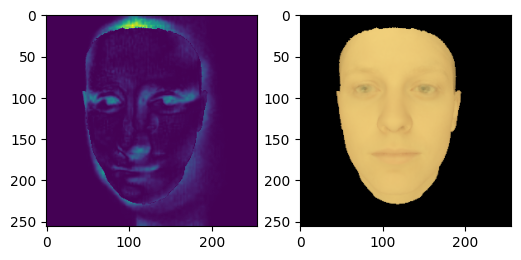

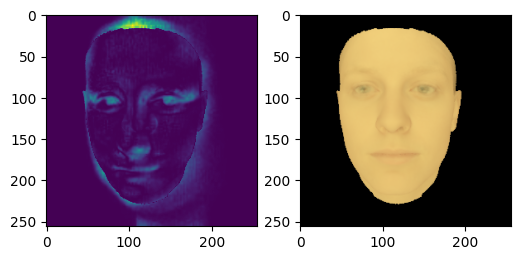

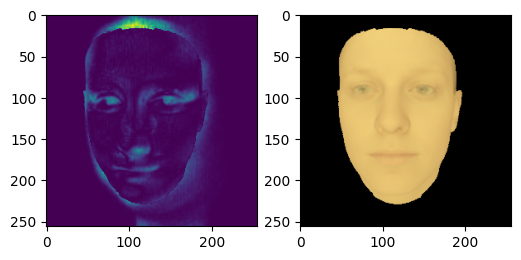

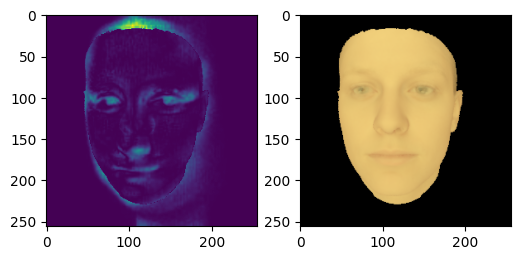

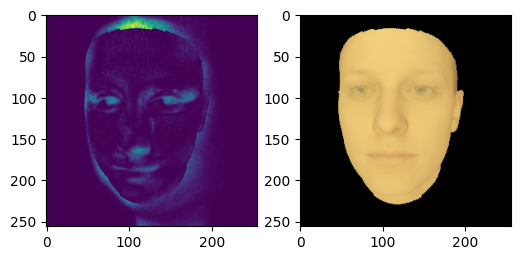

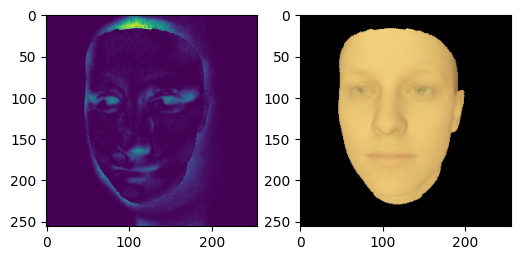

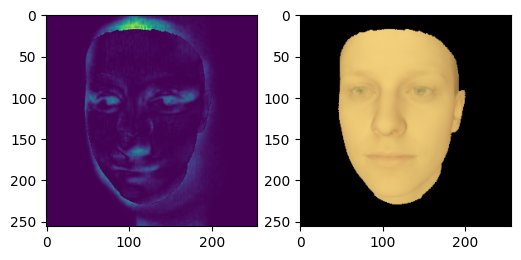

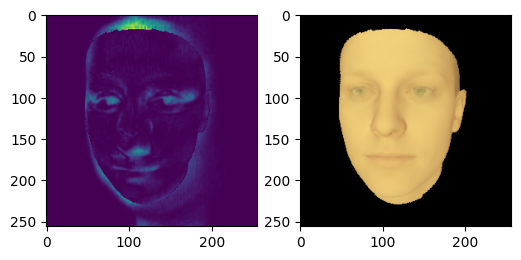

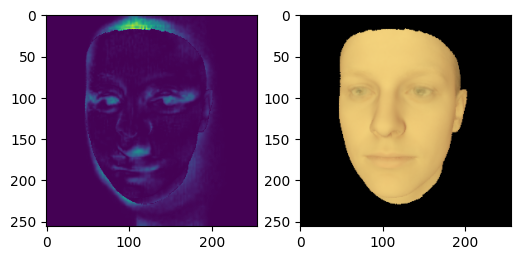

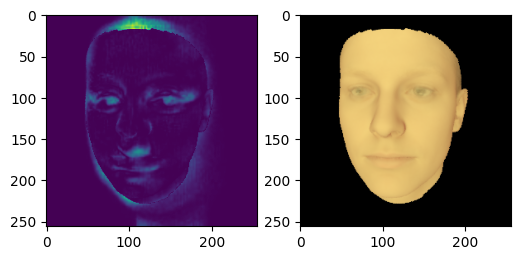

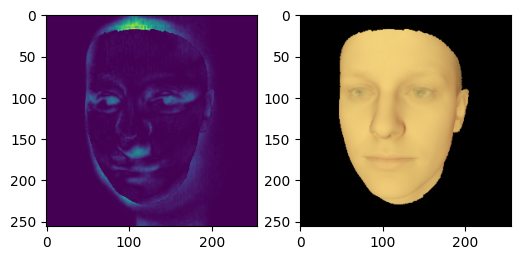

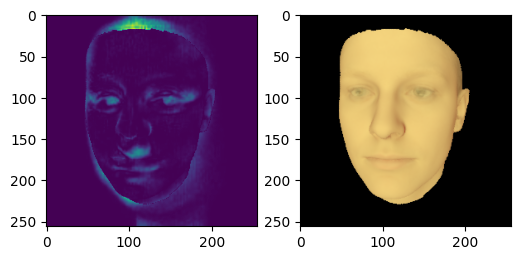

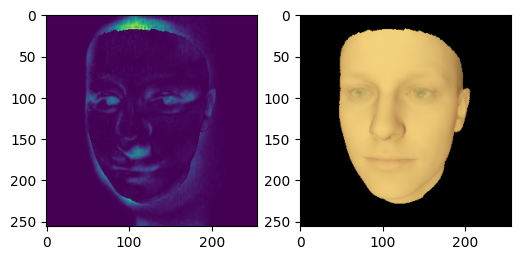

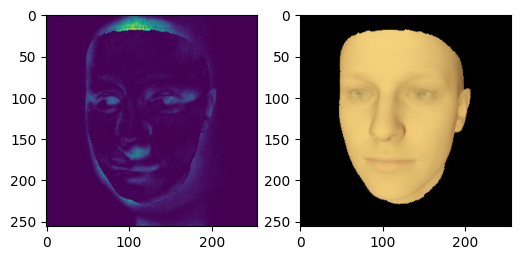

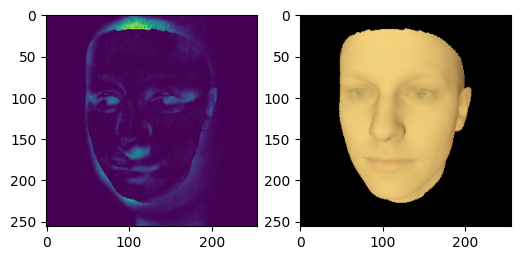

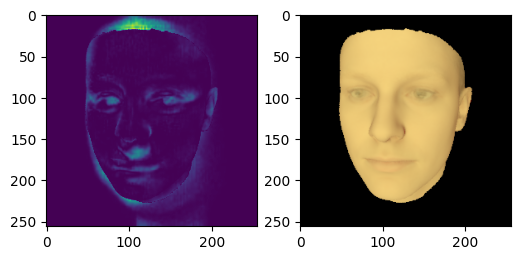

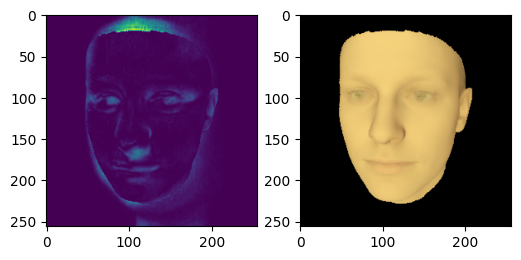

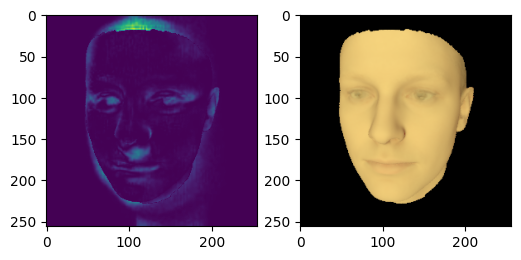

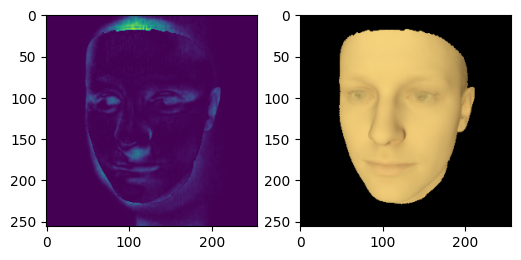

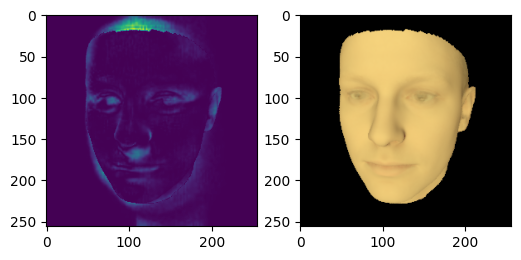

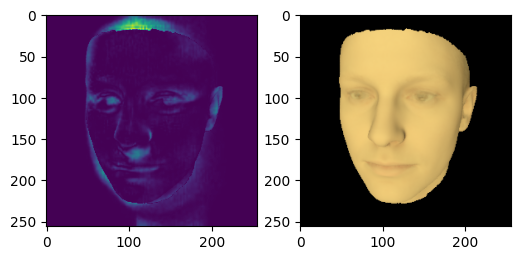

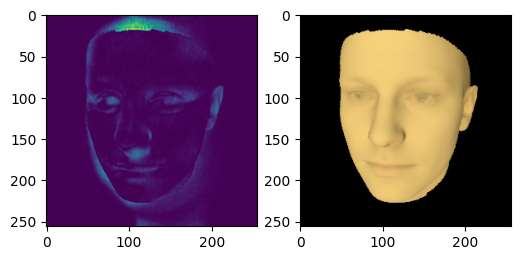

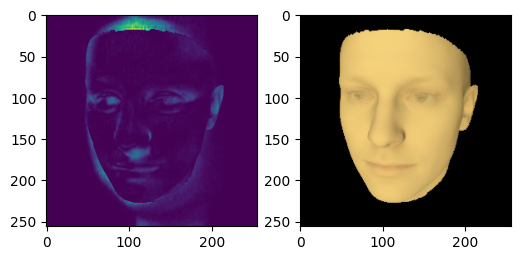

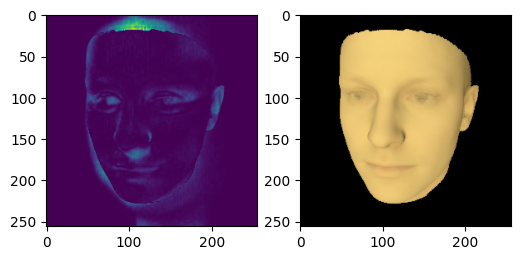

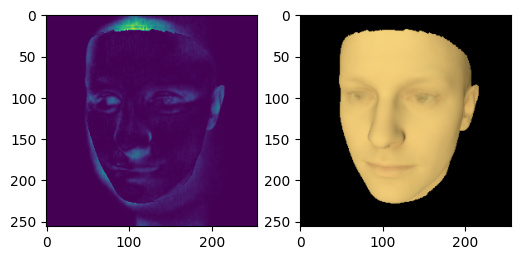

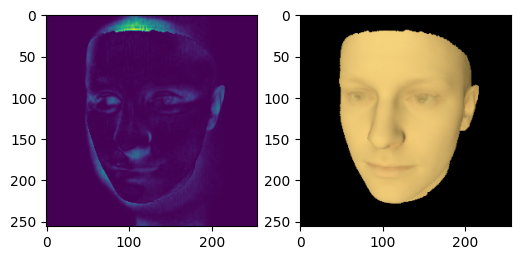

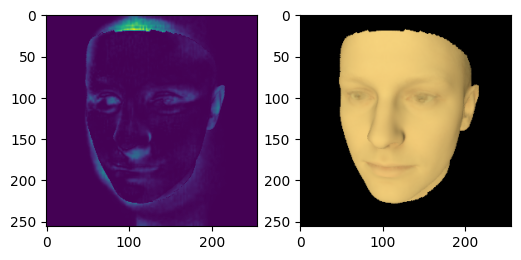

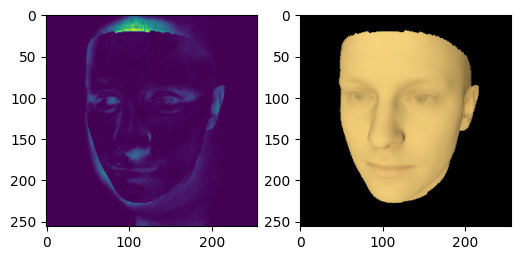

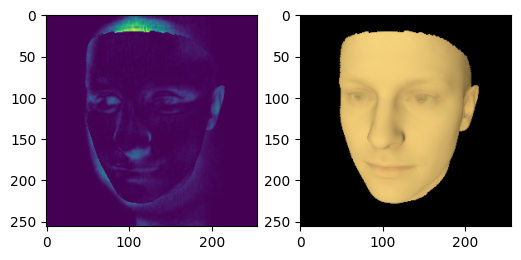

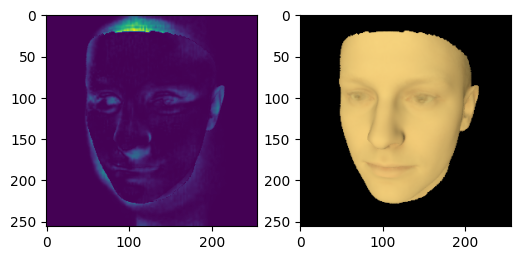

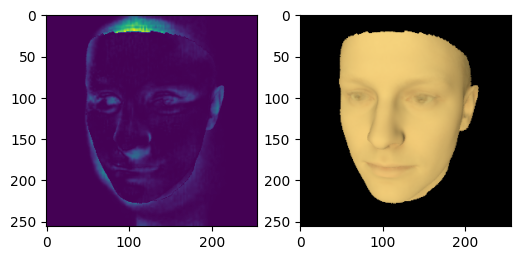

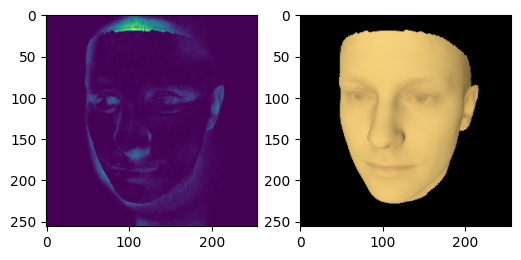

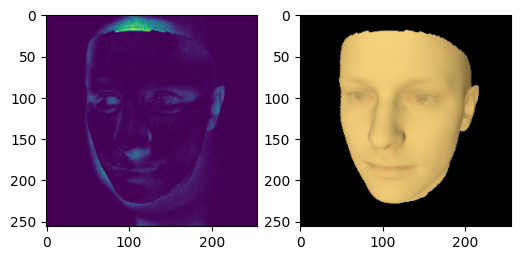

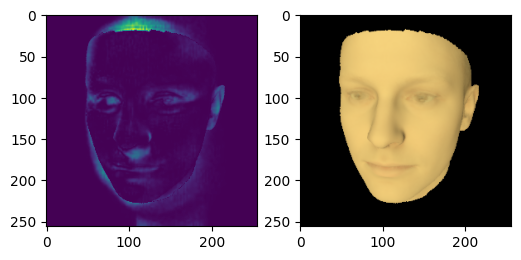

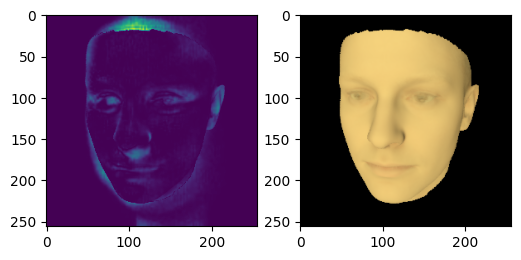

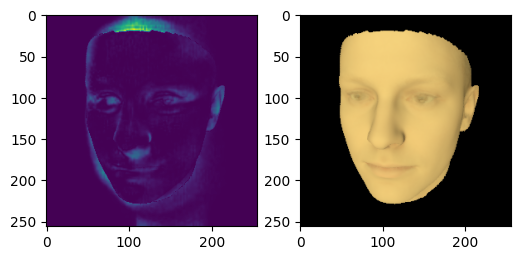

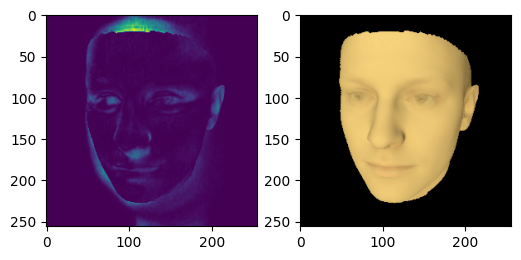

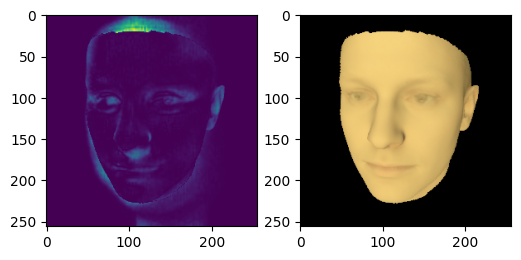

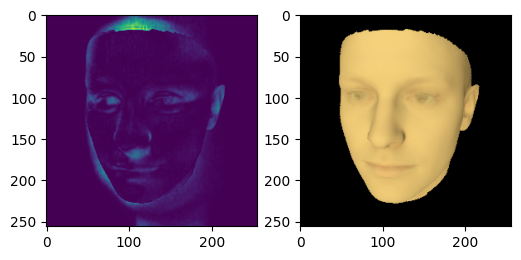

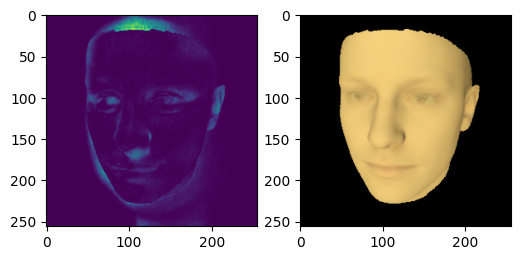

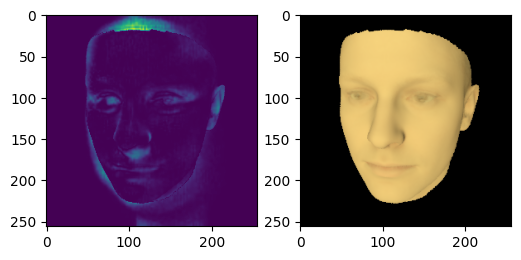

In [100]:
for img in imgs:
    fig = plt.figure(figsize=(6, 6))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow((img - target).pow(2).sum(dim=2).data.cpu())

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(torch.pow(img.data.cpu(), 1.0/2.2))

plt.show()

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3. Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>